In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
import math


import seaborn as sns

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [2]:
sales           = pd.read_csv('sales_train.csv.gz')
items           = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
test            = pd.read_csv('test.csv.gz')

In [3]:
print('training set: ', sales.shape)
print('test set: ', sales.shape)
print('num of shops: ', shops.shape)
print('num of items: ',items.shape)
print('num of item categories: ',item_cats.shape)

training set:  (2935849, 6)
test set:  (2935849, 6)
num of shops:  (60, 2)
num of items:  (22170, 3)
num of item categories:  (84, 2)


In [4]:
# combining train and test for EDA

sales['ID'] = sales.index
sales['set'] = 'train'
test['set'] = 'test'
test['item_price'] = np.nan
test['item_cnt_day'] = np.nan
test['date_block_num'] = 34
test['date'] = '30.11.2015'

In [5]:
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'ID', 'set'],
      dtype='object')

In [6]:
test.columns

Index(['ID', 'shop_id', 'item_id', 'set', 'item_price', 'item_cnt_day',
       'date_block_num', 'date'],
      dtype='object')

In [7]:
sales_train = sales[['ID', 'set', 'date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']]
sales_test = test[['ID', 'set', 'date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']]

In [8]:
all_data = sales_train.append(sales_test)

all_data.head()

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,train,02.01.2013,0,59,22154,999.00,1.0
1,1,train,03.01.2013,0,25,2552,899.00,1.0
2,2,train,05.01.2013,0,25,2552,899.00,-1.0
3,3,train,06.01.2013,0,25,2554,1709.05,1.0
4,4,train,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
# merge with other data
all_data = all_data.merge(shops, how = 'left', on = 'shop_id')
all_data = all_data.merge(items, how='left', on='item_id')
all_data = all_data.merge(item_cats, how = 'left', on = 'item_category_id')
all_data.head()

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,0,train,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,1,train,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2,train,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,3,train,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,4,train,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [10]:
# set up date features
all_data['date'] = pd.to_datetime(all_data['date'], format='%d.%m.%Y')
all_data['month'] = all_data['date'].dt.month
all_data['year'] = all_data['date'].dt.year
all_data['day'] = all_data['date'].dt.day
all_data['weekday'] = all_data['date'].dt.weekday

In [11]:
# creating revenue feature
all_data['revenue'] = all_data['item_cnt_day'] * all_data['item_price']
# interaction feature
all_data['shop_item'] = all_data['shop_id'].map(str) + '_'+ all_data['item_id'].map(str)

In [12]:
all_data.head()

,ID,set,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,month,year,day,weekday,revenue,shop_item
0,0,train,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,1,2013,2,2,999.00,59_22154
1,1,train,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,3,3,899.00,25_2552
2,2,train,2013-01-05,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,1,2013,5,5,-899.00,25_2552
3,3,train,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,1,2013,6,6,1709.05,25_2554
4,4,train,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,1,2013,15,1,1099.00,25_2555


# Revenue over time 

/Users/davidaponte/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/davidaponte/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


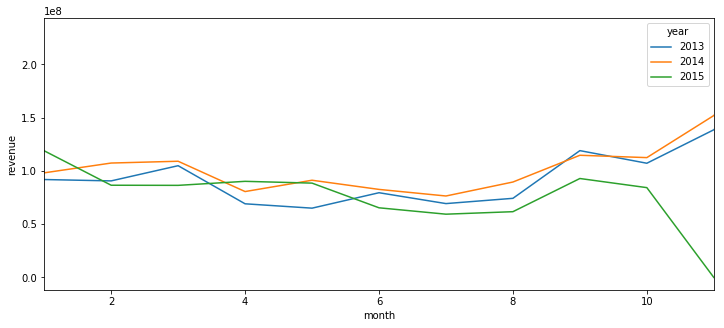

In [13]:

gb = all_data.groupby(['year','month'], as_index=False)['revenue'].sum()
gb = pd.DataFrame(gb)

plt.figure(figsize=(12, 5))
sns.tsplot(gb, time='month', unit='year', condition='year', value='revenue')

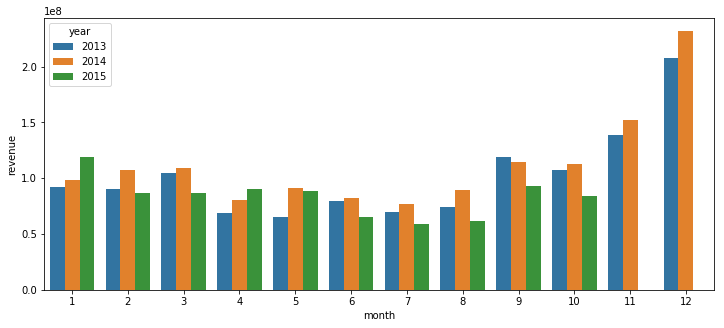

In [14]:
plt.figure(figsize=(12, 5))
sns.barplot(x='month', y='revenue', hue='year', data=gb)

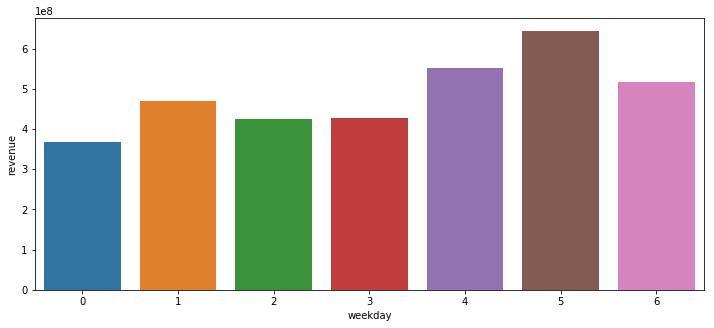

In [15]:
gb = all_data.groupby(['weekday'], as_index=False)['revenue'].sum()
gb = pd.DataFrame(gb)

plt.figure(figsize=(12, 5))
sns.barplot(x='weekday', y='revenue', data=gb)

# Revenue by Item Category

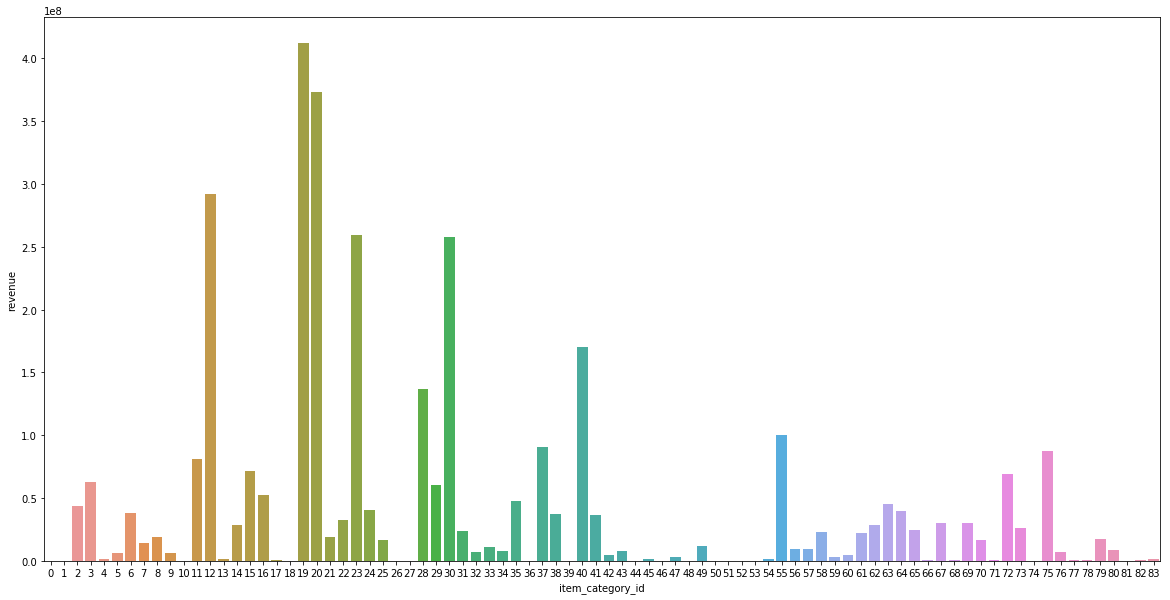

In [16]:
gb = all_data.groupby(['item_category_id'], as_index=False)['revenue'].sum()
gb = pd.DataFrame(gb)

plt.figure(figsize=(20, 10))
sns.barplot(x='item_category_id', y='revenue', data=gb)

# Revenue by Shop

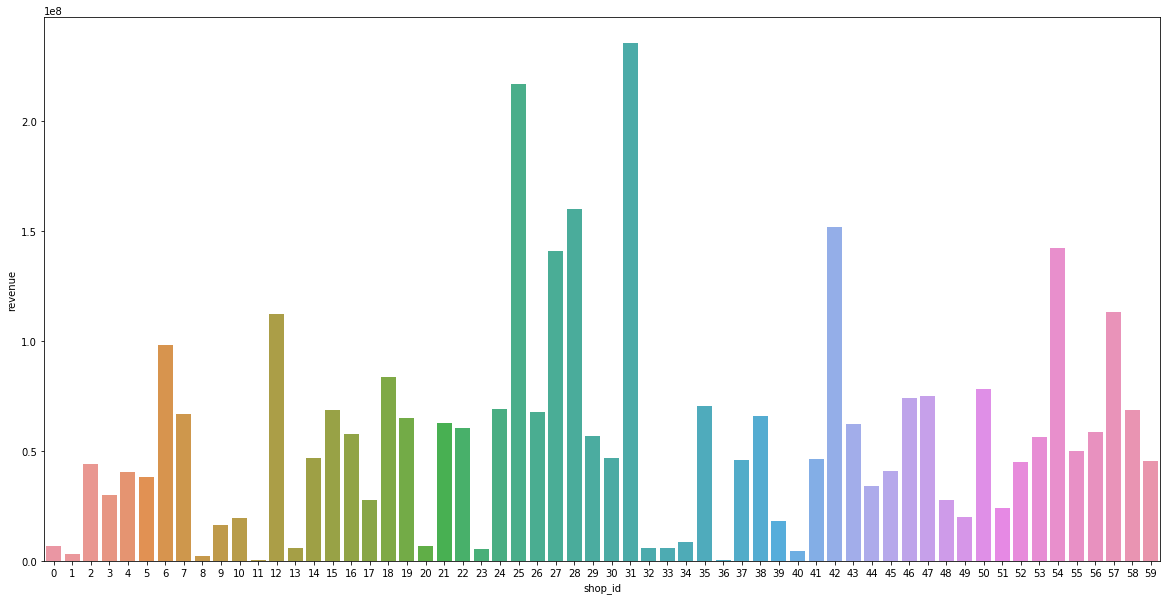

In [17]:
gb = all_data.groupby(['shop_id'], as_index=False)['revenue'].sum()
gb = pd.DataFrame(gb)

plt.figure(figsize=(20, 10))
sns.barplot(x='shop_id', y='revenue', data=gb)

# Exploring the Target

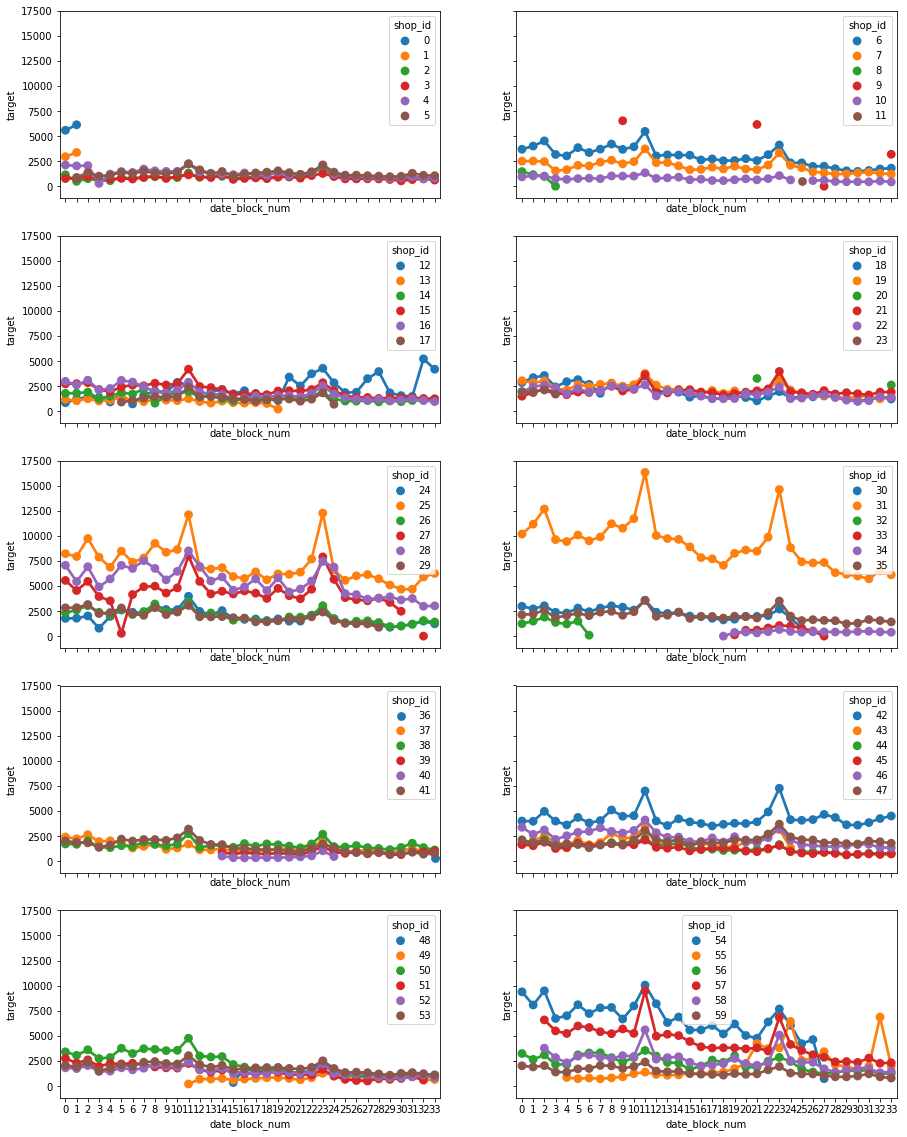

In [18]:
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].agg({"target": np.sum})

# count to keep track
count = 0
# num of plots
num_graph = 10
# num of plots per graph
num_per_graph = math.ceil(sales['shop_id'].max()/num_graph)

fig, ax = plt.subplots(nrows=5,
                      ncols=2,
                      sharex=True,
                      sharey=True,
                      figsize=(15,20))

# iterate through 5 rows
for i in range(5):
    # iterate through cols
    for j in range(2):
        
        data = gb[np.logical_and(count*num_per_graph <= gb['shop_id'], gb['shop_id'] < (count+1)*num_per_graph)]
        sns.pointplot(x='date_block_num', y='target', hue='shop_id', data=data, ax=ax[i][j])
        
        count += 1




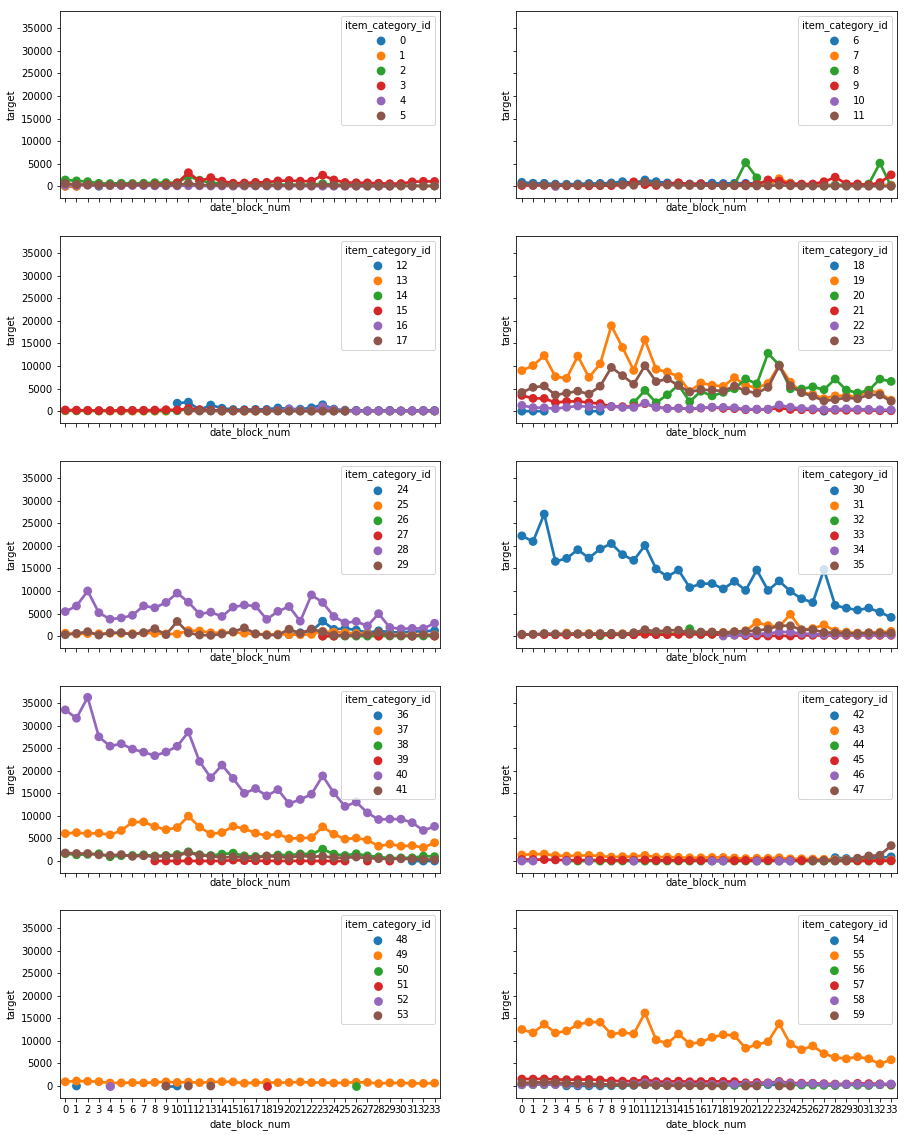

In [19]:
items_ = items[['item_id', 'item_category_id']].copy()

sales_ = sales.merge(items_, how='left', on='item_id')

gb = sales_.groupby(['item_category_id', 'date_block_num'], as_index=False)['item_cnt_day'].agg({"target": np.sum})

# count to keep track
count = 0
# num of plots
num_graph = 10
# num of plots per graph
num_per_graph = math.ceil(sales['shop_id'].max()/num_graph)

fig, ax = plt.subplots(nrows=5,
                      ncols=2,
                      sharex=True,
                      sharey=True,
                      figsize=(15,20))

# iterate through 5 rows
for i in range(5):
    # iterate through cols
    for j in range(2):
        
        data = gb[np.logical_and(count*num_per_graph <= gb['item_category_id'], gb['item_category_id'] < (count+1)*num_per_graph)]
        sns.pointplot(x='date_block_num', y='target', hue='item_category_id', data=data, ax=ax[i][j])
        
        count += 1



